In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, dataloader
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from datagen import *

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()

Running on CPU


## Dataset

This isnt actually in use, just to test datagen code. The datagen function is directly coded in training method in model.

In [17]:
# Dataclass for adding problem

class Datamodel(Dataset):
    def __init__(self,time_pos_points,labels):
        self.x = time_pos_points
        self.y = labels
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [18]:
n_data = 2000
t_steps = 40

# data,labels = datagen_full_sum_normal(n_data,t_steps,normalize=True)
data,labels = datagen_circular_pm(n_data,t_steps)
# data,labels = datagen_timewise_labels(n_data,t_steps,2)
# print(data[1],labels[1])

BATCH_SIZE = 64 # NOT IN USE FOR TRAINING

training_data = Datamodel(data,labels)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

data.shape

torch.Size([2000, 40, 1])

In [19]:
k = 15

print(labels[k])
print(data[k])

tensor([3.3877e+00, 2.9727e+00, 3.3078e+00, 2.8979e+00, 3.0065e+00, 2.6237e+00,
        1.6563e+00, 1.2837e+00, 6.9311e-01, 1.8790e-03, 8.1185e-02, 3.9206e-01,
        9.4418e-01, 6.1422e-01, 5.5175e-01, 3.4864e-01, 1.5869e-01, 2.3749e+00,
        2.1160e+00, 3.8108e+00, 2.7424e+00, 2.6476e+00, 2.3813e+00, 2.0309e+00,
        1.9653e+00, 2.3367e+00, 1.9438e+00, 2.2188e+00, 2.9389e+00, 4.1036e+00,
        3.9253e+00, 3.6673e+00, 4.3289e+00, 4.2823e+00, 4.9583e+00, 5.8605e+00,
        5.3578e+00, 5.6265e+00, 4.5354e+00, 4.1772e+00])
tensor([[ 0.0392],
        [-0.0661],
        [ 0.0533],
        [-0.0652],
        [ 0.0173],
        [-0.0609],
        [-0.1540],
        [-0.0593],
        [-0.0940],
        [-0.1100],
        [ 0.0126],
        [ 0.0495],
        [ 0.0879],
        [-0.0525],
        [-0.0099],
        [-0.0323],
        [-0.0302],
        [ 0.3527],
        [-0.0412],
        [ 0.2697],
        [-0.1700],
        [-0.0151],
        [-0.0424],
        [-0.0558],
       

## Model training

100%|██████████| 3000/3000 [01:19<00:00, 37.96it/s]


Last training time steps: 61


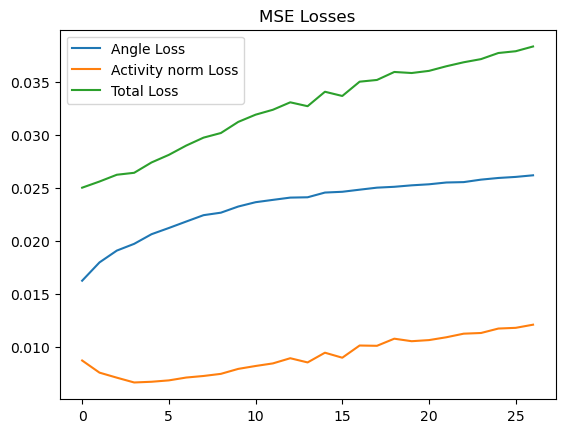

Guess on the first 15 training data:  tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.9007, 0.1303, 0.0908,  ..., 0.0000, 0.0000, 0.0000],
         [0.8547, 0.2105, 0.1543,  ..., 0.0000, 0.0000, 0.0000],
         [1.2100, 0.0000, 0.0000,  ..., 0.4734, 0.2651, 0.2753],
         ...,
         [0.9899, 0.0000, 0.0000,  ..., 0.0075, 0.0000, 0.0000],
         [1.0638, 0.0000, 0.0000,  ..., 0.1639, 0.0733, 0.0736],
         [0.8874, 0.1535, 0.1092,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.9692, 0.0000, 0.0000,  ..., 0.1357, 0.0000, 0.0000],
         [0.7954, 0.2069, 0.0973,  ..., 0.0000, 0.0000, 0.0000],
         [0.7653, 0.

In [25]:
hidden_size = 128
input_size = 1
nav_size = 1

train1 = True

if train1:
    # model2 = torch_RNN1(input_size,t_steps,output_size,hidden_size,lr=0.01,irnn=True,outputnn=False,Wx_normalize=True)
    # model1 = torch_RNN_full_manual(input_size,t_steps,output_size,hidden_size,lr=0.001,irnn=False,outputnn=True,Wx_normalize=False,activation=False)
    # model1 = RNN_L2(input_size,t_steps,output_size,hidden_size,lr=0.001,w_decay=0.000,act_decay=1000,irnn=False,outputnn=True,Wx_normalize=False,activation=False)
    # model1 = RNN_circular_ND_pm(input_size,t_steps,output_size,hidden_size,lr=0.0001,w_decay=0.000,act_decay=0.01,irnn=True,outputnn=False,Wx_normalize=False,activation=True,rotation_init=False,bias=False)
    model1 = RNN_circular_LowEtAl_bridged_reduced(input_size,hidden_size,lr=0.0001,irnn=True,outputnn=False,Wx_normalize=False,activation=True,bias=False,nav_space=1,batch_size=64,time_back=2).to(device)
    # print("Guess on the first 15 training data: ", model1(data[0:15]))
    # _ = model1.train(epochs=7000)
    _ = model1.train_gradual(epochs=3000)
    model1.plot_losses(average=30)
    # model1.plot_accs()
    print("Guess on the first 15 training data: ", model1(data[0:15]))
    # print("Weight of the hidden layer: ",model2.rnn.weight_hh_l0, " Weight of the input layer: ",model2.rnn.weight_ih_l0)

100%|██████████| 2000/2000 [01:12<00:00, 27.56it/s]


Losses array was not a multiple of average. Truncated to 4980


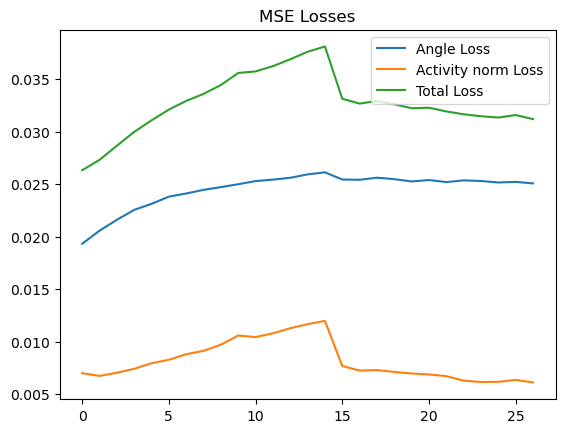

In [26]:
model1.base_training_tsteps = 41

_ = model1.train(epochs=2000)
# model1.plot_losses(average=30)
model1.plot_losses(average=30)

torch.Size([41, 15])


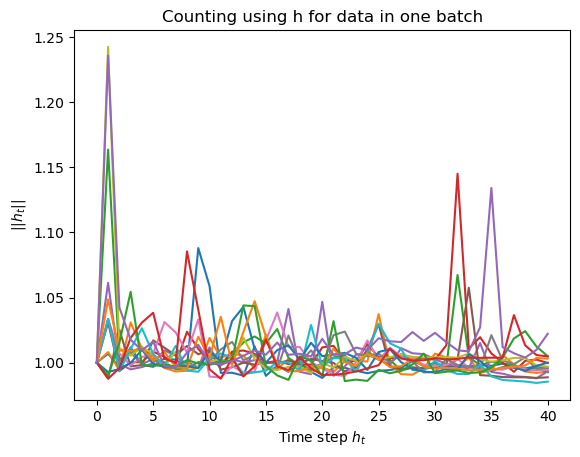

In [21]:
print(model1.hts.norm(dim=2).shape)
htss = model1.hts.norm(dim=2)
plt.plot(htss.cpu().detach().numpy())
plt.title("Counting using h for data in one batch")
plt.xlabel(r"Time step $h_t$")
plt.ylabel(r"$||h_t||$")
plt.show()

torch.Size([42, 64, 128])


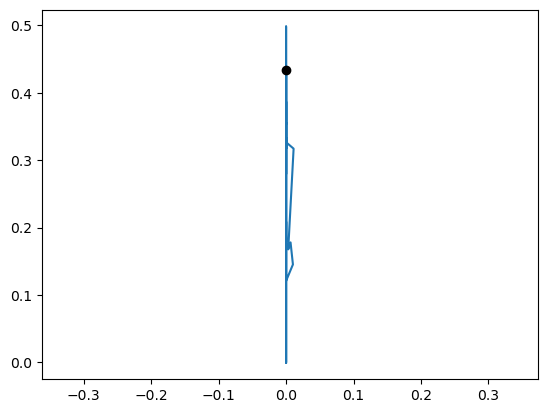

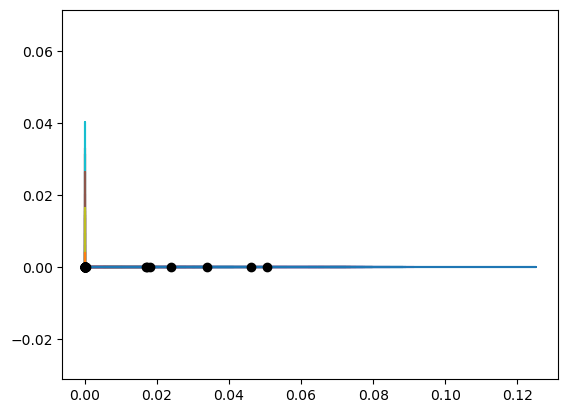

In [12]:
n = 0
print(model1.hts.shape)
model1.hts[:,n,:].shape
hts_cric = model1.hts.cpu().detach().numpy()
plt.plot(hts_cric[:,n,90],hts_cric[:,n,76],"-")
plt.plot(hts_cric[-1,n,90],hts_cric[-1,n,76],"o",color="black")
plt.axis("equal")
plt.show()
plt.plot(hts_cric[:,:,16],hts_cric[:,:,125],"-")
plt.plot(hts_cric[-1,:,16],hts_cric[-1,:,125],"o",color="black")
plt.axis("equal")
plt.show()

In [13]:
# See what dimension has the highest values

maxs = []

for i in range(128):
    maxs.append(max(hts_cric[:,n,i]))

# Sorted dimension from lowest to highest value in that dimension
print(torch.argsort(torch.tensor(maxs),dim=-1))

tensor([ 16,   1, 100,   3,   4,   5,  97,  96,   8, 111,  62,  11,  12,  63,
         14, 102, 106,  92, 108,  19,  20, 109,  89, 114, 118,  25,  88,  27,
         28, 119,  83, 125,  79,  33,  34,  35,  36,  37, 126,  39,  78,  41,
         42,  44,  77,  47,  48,  50,  51,  52,  75,  54,  56,  70,  69,  67,
         65,  24, 115,  21,  90,  49,  38,  64, 101,  23, 105,  45,  85, 110,
         43,  13,  74,  61,  94, 117,  93, 104,  80, 127, 103,  60,  86,  98,
         71,  59,  72,  29,  32,  99,  53, 124,  81,   2, 123,  66,   6,  82,
         68,  95, 112,  15,  31,  58, 122,  22, 113,  40,  55,  17,  10,  57,
         46,   9,  91,   7,  73,  26,  30,  84,  87,  18, 120,  76, 107, 121,
        116,   0])


(39, 5000)
(39, 5000)


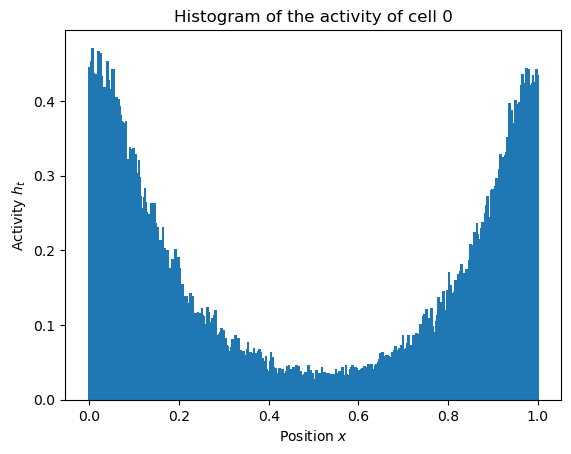

100%|██████████| 128/128 [00:02<00:00, 53.40it/s]


In [66]:
t_test = 40

# data,labels = datagen_circular_pm(5000,t_test,sigma=0.1,bound=0.5)
data, _, labels = datagen_lowetal(5000,t_test)

test_batch_size = 5000

# xs = data[0:test_batch_size]
xs = labels[0:test_batch_size,:-1]/(2*np.pi)
xs = xs.cpu().detach().numpy().T
print(xs.shape)

# Get the hidden states for the test data
hts = model1(data[0:test_batch_size],raw=True)
# print(hts.shape)

# Grid-cell histogram

hts = hts.cpu().detach().numpy() # Shape [t_steps, batch_size, hidden_size] = [21, 64, 128]

k = 0 # What cell to see the histogram of

hts_k = abs(hts[1:-1,:,k])
print(hts_k.shape)

bins = 1000

import scipy.stats as stats

bin_means, bin_edges, binnumber = stats.binned_statistic(xs.flatten(),hts_k.flatten(),statistic='mean',bins=bins)
# Bar plot of the histogram
plt.bar(bin_edges[:-1],bin_means,width=6/bins)
plt.title("Histogram of the activity of cell "+str(k))
plt.xlabel(r"Position $x$")
plt.ylabel(r"Activity $h_t$")
plt.show()

# print(hts.shape)

# fig, ax = plt.subplots(32,4,subplot_kw={'projection': 'polar'})
# fig.set_size_inches(15, 80)
# fig.subplots_adjust(hspace=1,wspace=0.2)

activity = np.zeros((128,bins))

for k in tqdm(range(128)):
    # k = 103 # What cell to see the histogram of
    hts_k = abs(hts[1:-1,:,k])
    # print(hts_k.shape)

    # Bins equally spaced from 0 to 1 in time_steps amount of bins
    bin_means, bin_edges, binnumber = stats.binned_statistic(xs.flatten(),hts_k.flatten(),statistic='mean',bins=bins)
    activity[k,:] = bin_means
    np.nan_to_num(activity,copy=False)
    # Bar plot of the histogram
    # ax[k//4,k%4].bar(bin_edges[:-1]*2*np.pi,bin_means,width=6/bins)
    # # ax[].bar(bin_edges[:-1]*2*np.pi,bin_means,width=6/bins)
    # ax[k//4,k%4].set_title("Cell "+str(k))
    # Adjust space between subplots

# plt.show()

(1000, 2)


Text(0.5, 1.0, 'UMAP projection of the activity of the grid cells')

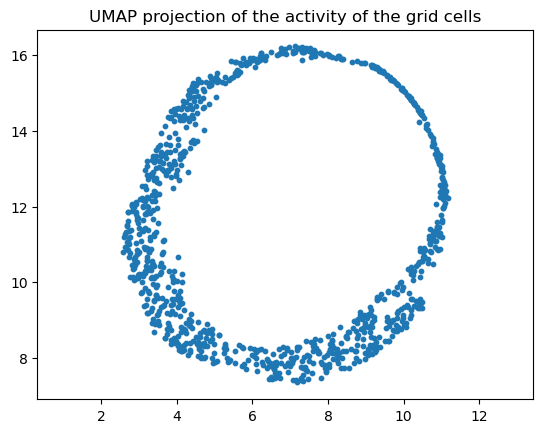

In [67]:
import umap

# draw_umap(activity.T,n_components=2, title='UMAP projection of the activity of the grid cells')
reducer = umap.UMAP(n_neighbors=500, n_components=2)
reducer.fit(activity.T)
embedding = reducer.transform(activity.T)

print(embedding.shape)


plt.scatter(embedding[:, 0], embedding[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the activity of the grid cells', fontsize=12)


In [32]:
print(model1(data[10:11]))
print(data[10:11])
print(labels[10:11])

tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.9617, 0.0191, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.7752, 0.2787, 0.1918,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0000, 0.1010, 0.0000,  ..., 1.3201, 0.0000, 0.0000]],

        [[0.0000, 0.0521, 0.0000,  ..., 1.3438, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 1.4385, 0.0000, 0.0000]]],
       grad_fn=<CopySlices>)
tensor([[[-0.0593],
         [-0.5011],
         [ 0.0175],
         [ 0.3886],
         [-0.1160],
         [-0.1112],
         [-0.3514],
         [ 0.2696],
         [ 0.5907],
         [ 0.0116],
         [ 0.1795],
         [-0.0454],
         [ 0.1277],
         [ 0.0009],
         [ 0.0799],
         [-0.0991],
         [-0.0829],
         [ 0.4895],
         [ 0.1560],
         [ 0.5165],
         [ 0.5413],
         [ 0.2738],
         [-0.0019],
         [ 0.4944],
         [-0.4865],
         [-0.1109],
         [ 0.1606],
         [ 0.13

(40,)


(0.40263659358024595,
 1.0284449398517608,
 -0.9885965257883071,
 0.9096516638994216)

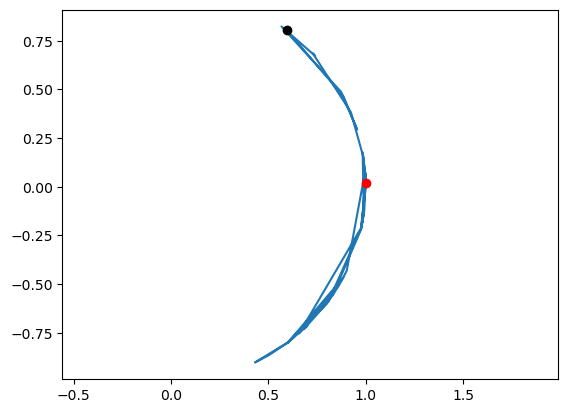

In [47]:
t_test = 40

# data,labels = datagen_circular_pm(1000,t_test,sigma=0.1,bound=0.5)
# data,labels, _ = datagen_lowetal(1000,t_test)
data,_, labels = datagen_lowetal(1000,t_test)


# Plot circle from data
data_raw = labels[122].cpu().detach().numpy()
print(data_raw.shape)
# print(data_raw)
data_points = np.zeros((t_test,2))
for i in range(t_test):
    data_points[i,0] = np.cos(data_raw[i])
    data_points[i,1] = np.sin(data_raw[i])
    # data_points[i,0] = data_raw[i,0]
    # data_points[i,1] = data_raw[i,1]


plt.plot(data_points[:,0],data_points[:,1],"-")
plt.plot(data_points[-1,0],data_points[-1,1],"o",color="black")
plt.plot(data_points[0,0],data_points[0,1],"o",color="red")
plt.axis("equal")

(41, 128)
torch.Size([41])


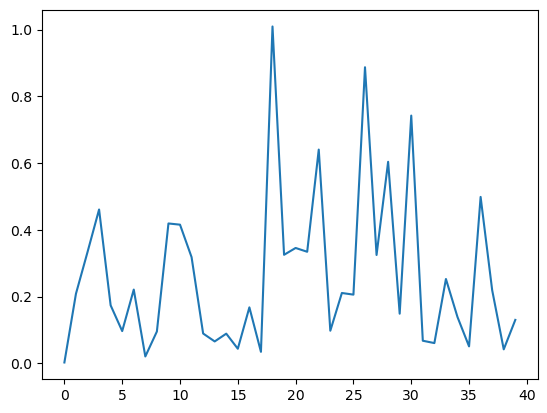

In [137]:
# Accuracy test

data,labels = datagen_circular_pm(1000,t_test,sigma=0.1,bound=0.5)
# data,_, labels = datagen_lowetal(1000,t_test)

test_batch_size = 1000

y_hat = model1(data[0:1],raw=True)[:,0,:]
y_hat = y_hat.cpu().detach().numpy()
y = labels[0:1]
# Concatenate pi to the start of y
y = torch.cat((torch.tensor([np.pi]),y[0]))

print(y_hat.shape)
print(y.shape)
 
err = np.zeros((t_test))
angs = np.zeros((t_test))

dy = np.zeros((t_test))
for i in range(1,len(y)):
    dy[i-1] = np.abs(y[i]-y[i-1])

for i in range(1,len(y_hat)):
    y_hat_i_normalized = y_hat[i]/np.linalg.norm(y_hat[i])
    y_hat_i_minus_1_normalized = y_hat[i-1]/np.linalg.norm(y_hat[i-1])
    # print(y_hat_i_normalized @ y_hat_i_minus_1_normalized)
    # Angle between y_hat[i] and y_hat[i-1]
    ang = np.arccos(y_hat_i_normalized @ y_hat_i_minus_1_normalized)
    # print(np.rad2deg(ang))
    angs[i-1] = ang
    # err[i-1] = np.abs(ang - np.abs(y[i]-y[i-1]))

err = np.abs(angs - dy)
# print(angs)
# print(dy)
plt.plot(err)

In [ ]:
# print(model1.input.weight)
print(model1.hidden.weight)
# print(model1.Wh_init)
# print(model1.output.weight)

Parameter containing:
tensor([[ 9.7316e-01, -2.3343e-02, -2.1827e-02,  ..., -1.0315e-02,
         -2.2785e-02, -2.1353e-02],
        [-1.0513e-02,  9.9223e-01, -6.7781e-03,  ...,  1.1700e-02,
          2.7143e-03, -9.6948e-04],
        [-3.3636e-02, -2.8345e-02,  9.6900e-01,  ..., -2.7289e-02,
         -3.9259e-02, -3.7641e-02],
        ...,
        [ 5.2839e-03,  1.8591e-03, -4.1440e-03,  ...,  9.8374e-01,
         -1.6406e-02, -1.4466e-02],
        [-1.1366e-02, -9.8762e-03, -1.3468e-02,  ..., -1.3232e-02,
          9.7735e-01, -1.9435e-02],
        [-5.0514e-03, -3.9373e-03, -6.7584e-03,  ..., -3.0696e-03,
         -9.5602e-03,  9.9180e-01]], requires_grad=True)


In [53]:
# hc = 0
# for h in model2.hts[0][0]:
#     hc += h

# np.linalg.norm(model2.hts[0,0].detach().numpy())
an1 = model1.hts[:,0,:]
an1 = an1.detach().numpy()
print(an1.shape)

for i in range(1,len(an1)):
    an1_i_normalized = an1[i]/np.linalg.norm(an1[i])
    an1_i_minus_1_normalized = an1[i-1]/np.linalg.norm(an1[i-1])
    # print(an1_i_normalized @ an1_i_minus_1_normalized)
    # Angle between an1[i] and an1[i-1]
    ang = np.arccos(an1_i_normalized @ an1_i_minus_1_normalized)
    print(np.rad2deg(ang))



(41, 128)
40.43025
18.55277
15.043392
13.918214
34.003193
8.591737
57.42095
52.6196
15.415641
31.671062
30.200697
31.379196
22.611809
29.12188
29.275177
19.285883
29.354082
10.664093
39.106575
20.437395
33.849876
27.636566
15.261437
23.538338
32.810936
19.879673
19.79651
23.129168
13.461444
32.977287
34.72162
17.746819
8.654035
18.542032
24.481312
6.000642
12.838162
5.4204683
18.367447
11.879322


In [54]:
# SVD of the weight matrix Wh

Wh = model1.hidden.weight.detach().numpy()
U, s, Vh = np.linalg.svd(Wh)
print("Singular values of Wh: ",s)

np.prod(s)
np.linalg.det(Wh)

Singular values of Wh:  [3.1149035  1.8778298  1.8193382  1.2439351  1.216888   1.1752474
 1.1447499  1.1026834  1.0946614  1.0853133  1.0629171  1.0571793
 1.0519872  1.0425276  1.0323733  1.0300205  1.0293957  1.0239465
 1.0222715  1.019625   1.0172442  1.0159768  1.0133916  1.0124424
 1.0105451  1.0102341  1.0089567  1.0076522  1.0070268  1.0057929
 1.0049242  1.0043573  1.0036     1.0032427  1.0030098  1.002719
 1.0018927  1.0018449  1.0012299  1.0011592  1.0009233  1.0007406
 1.000593   1.0004604  1.0003624  1.0003276  1.0003036  1.0002651
 1.0001284  1.0000988  1.0000962  1.0000588  1.0000378  1.000023
 1.0000136  1.0000083  1.0000063  1.0000037  1.0000021  1.0000018
 1.0000012  0.9999975  0.99999505 0.99999374 0.99998784 0.9999831
 0.99998206 0.9999705  0.99996614 0.9999404  0.99991685 0.999904
 0.9998757  0.9998458  0.9998091  0.9997744  0.99972236 0.99961853
 0.9995246  0.9994657  0.9993626  0.9992848  0.99916965 0.9990067
 0.99882895 0.9985873  0.99849004 0.9981116  0.9978595

-0.03550357

### Test baseline loss if you guess only zeros

In [55]:
y_hat = labels
act_decay = 0.01
time_steps = t_steps
# y = torch.ones(time_steps+1,y_hat.shape[0],hidden_size)/np.sqrt(hidden_size)
y = torch.zeros(time_steps+1,y_hat.shape[0],hidden_size)
y[:,:,4] = 0
y[:,:,0] = 1

activity_L2 = act_decay*((torch.norm(y,dim=-1)-1)**2).sum()

# Concatenate 0 to y_hat to make it the same size as y
y_hat = torch.cat((torch.zeros(y_hat.size(0),1),y_hat),dim=1)
# Permute y_hat to make it the same size as y
y_hat = y_hat.permute(1,0)
# angle_loss = 0


# Theoretical 0 loss
# print(y_hat.shape)
# # y = torch.zeros(time_steps+1,y_hat.shape[0],hidden_size)
# print(y.shape)
# for i in range(t_steps+1):
#     y[i,:,0] = torch.cos(y_hat[i])
#     y[i,:,1] = torch.sin(y_hat[i])

# print((torch.norm(y,dim=-1).shape))


        


# Main angle loss loop
i = torch.arange(1, time_steps).unsqueeze(1)
j = torch.arange(1, time_steps//2-int(time_steps*0.1)).unsqueeze(0)
mask = (i > j).float()
j = j * mask
# Convert i and j to int
i = i.long()
j = j.long()
normalizer = 1 / (torch.norm(y[i], dim=-1) * torch.norm(y[i-j], dim=-1))
# Cant clamp between -1 and 1 because it will cause NaNs in training
angle_test = torch.abs(torch.acos(torch.clamp(torch.sum(y[i]*y[i-j], dim=-1) * normalizer, -0.999999, 0.999999)))
# Must use torch.abs because the angle can be negative, but the angle_test only returns positive angles
angle_theoretical = torch.abs(y_hat[i]-y_hat[i-j])
angle_loss = torch.mean((angle_test-angle_theoretical)**2)

# Loss to end in the same position as the start
# circle_end_loss = 0.0001*torch.mean((y[-1]-y[0])**2)

# losses_circle.append(circle_end_loss.item())
loss = angle_loss + activity_L2 # + circle_end_loss

loss
# loss
# torch.norm(y[1,0,:])
# y_hat.shape
# j1 = 16
# i1 = 1
# a = torch.abs(torch.acos(torch.clamp(torch.sum(y[i1,0,:]*y[j1,0,:], dim=-1) * (torch.norm(y[i1,0,:], dim=-1) * torch.norm(y[j1,0,:], dim=-1)), -0.99999, 0.99999)))
# b = y_hat[i1,0]-y_hat[j1,0]
# (a-abs(b))**2
# print(angle_theoretical[:,:,0])
# print(angle_test[:,:,0])
# torch.mean((angle_test-angle_theoretical)**2)

tensor(3.8335)

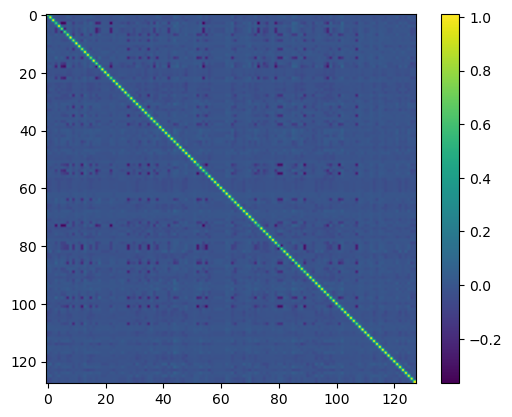

In [56]:
plt.imshow(model1.hidden.weight.detach().numpy())
plt.colorbar()

In [57]:
Wx = model1.input.weight.detach().numpy()
print("Norm of Wx: ",np.linalg.norm(Wx))

Norm of Wx:  5.3064275
